In [25]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

In [26]:
filenames = [file for file in tqdm(os.listdir("scripts"))]

100%|██████████| 2059/2059 [00:00<00:00, 539215.28it/s]


In [27]:
filenames

['No-Country-for-Old-Men.txt',
 'Jerry-Maguire.txt',
 'Addams-Family-The.txt',
 'Machine-Gun-Preacher.txt',
 'Things-My-Father-Never-Taught-Me-The.txt',
 'Next-Three-Days-The.txt',
 'Army-of-Darkness.txt',
 'The-Day-The-Clown-Cried.txt',
 'Dear-White-People.txt',
 'Sugar.txt',
 'Downsizing.txt',
 'Witness.txt',
 'Tarzans-Secret-Treasure.txt',
 'American-Bullshit-(filmed-as-American-Hustle).txt',
 'Ed-Wood.txt',
 'Seventh-Seal-The.txt',
 'Batman-Forever.txt',
 'Star-Wars-Attack-of-the-Clones.txt',
 'Working-Girl.txt',
 'Being-John-Malkovich.txt',
 'The-Replacements.txt',
 'Close-Encounters-of-The-Third-Kind-(part-2).txt',
 'Beloved.txt',
 'Maria-Full-of-Grace.txt',
 'Drag-Me-to-Hell.txt',
 'Mechanic-The.txt',
 'Broken-Embraces.txt',
 'War-for-the-Planet-of-the-Apes.txt',
 'Malibus-Most-Wanted.txt',
 'Conquest-of-Paradise-1492.txt',
 'Blood-and-Wine.txt',
 'Kafka.txt',
 'Portrait-of-Jennie.txt',
 'Empire-of-the-Sun.txt',
 '30-Minutes-or-Less.txt',
 'Bruce-Almighty.txt',
 'His-Girl-Friday

In [28]:
movie_scripts = []

for file in filenames:
    with open(f"scripts/{file}", 'r') as f:
        movie_scripts = movie_scripts + [f.read()]

In [30]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


tagged_data = [TaggedDocument(words=script.split(), tags=[str(i)]) for i, script in enumerate(movie_scripts)]

model = Doc2Vec(vector_size=300, window=5, min_count=1, workers=4, epochs=10)
model.build_vocab(tagged_data)


for epoch in tqdm(range(model.epochs), desc="Training Doc2Vec"):
    model.train(tagged_data, total_examples=model.corpus_count, epochs=1)
    model.alpha -= 0.002  
    model.min_alpha = model.alpha  


movie_vectors = [(title, model.dv[i].tolist()) for i, title in enumerate(filenames)]


Training Doc2Vec: 100%|██████████| 10/10 [05:36<00:00, 33.65s/it]


In [37]:
l = []
v = []

for pair in movie_vectors:
    l = l + [[pair[0][:-4].replace("-", " ")] + pair[1]]



In [51]:
dfscript = pd.DataFrame(l)
dfvectors = pd.DataFrame(movie_vectors)

dfscript.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,No Country for Old Men,-0.791124,-0.827768,-2.360581,1.835622,-0.538139,-1.668736,-2.025473,-0.549377,-1.938114,...,0.740493,0.132890,-0.852833,-0.949367,1.291457,1.415287,0.124992,-1.362445,0.973660,-2.840497
1,Jerry Maguire,1.562291,0.452415,-0.337816,0.626962,-1.066654,-1.055062,0.661907,1.013458,1.237970,...,0.501663,0.958692,0.578849,0.267543,-1.528411,-1.252558,-0.492581,-2.604457,-0.121499,-0.674109
2,Addams Family The,-0.781085,-0.268572,-1.152856,-0.789217,-1.480119,1.018391,-1.064225,-0.682331,-1.166818,...,-0.052997,1.384553,1.985418,-1.308616,1.100558,0.067445,-0.019421,0.164875,0.970920,0.310238
3,Machine Gun Preacher,0.848836,-0.905038,-2.310214,-2.289747,0.020413,1.066912,-0.593755,-0.625307,0.301042,...,-0.552724,0.439940,0.690638,0.452343,2.399996,-0.256926,0.426104,-0.822776,0.512721,-2.063717
4,Things My Father Never Taught Me The,0.216570,0.401216,-0.413419,0.825096,-0.884562,0.108544,-0.489815,0.583705,-0.433195,...,-0.393139,0.609140,-0.154283,-0.692036,0.095477,0.460662,-0.232961,-0.143289,0.398403,-0.832446


In [52]:
dfvectors[0] = dfvectors[0].str.replace("-", " ").apply(lambda x: x[:-4])

In [91]:
dfvectors.columns = ["Title", "Vector"]

In [92]:
dfvectors

,Title,Vector
0,No Country for Old Men,"[-0.7911235690116882, -0.8277679681777954, -2...."
1,Jerry Maguire,"[1.5622906684875488, 0.4524152874946594, -0.33..."
2,Addams Family The,"[-0.7810851335525513, -0.26857179403305054, -1..."
3,Machine Gun Preacher,"[0.8488364219665527, -0.9050384759902954, -2.3..."
4,Things My Father Never Taught Me The,"[0.21657003462314606, 0.40121644735336304, -0...."
...,...,...
2054,The Woodsman,"[-2.7763538360595703, 0.03289785608649254, 0.3..."
2055,Avenge,"[0.5537711381912231, 0.24020785093307495, 3.18..."
2056,An American Tragedy,"[-0.2541160583496094, -0.48454344272613525, 0...."
2057,Highlander 4,"[-2.033679723739624, 0.4417038559913635, -3.95..."


In [68]:
movie_selected = "No Country for Old Men"

sel_vector = np.array(dfvectors.loc[dfvectors['Title'] == movie_selected].values.flatten()[1])

In [93]:
dfvectors['Title']

0                     No Country for Old Men
1                              Jerry Maguire
2                          Addams Family The
3                       Machine Gun Preacher
4       Things My Father Never Taught Me The
                        ...                 
2054                            The Woodsman
2055                                  Avenge
2056                     An American Tragedy
2057                            Highlander 4
2058                           Lost in Space
Name: Title, Length: 2059, dtype: object

In [172]:
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity

def cosine_sim(A,B):
    return np.dot(A, B)/(norm(A)*norm(B))


In [116]:

def similar_movies(movie_selected):

    sel_vector = np.array(dfvectors.loc[dfvectors['Title'] == movie_selected].values.flatten()[1])

    l = []

    dfop = dfvectors.loc[dfvectors['Title'] != movie_selected]


    for i, movie in dfop.iterrows():
        mov_vector = np.array(movie['Vector'])
        similarity = cosine_sim(sel_vector, mov_vector)

        l = l + [[movie['Title']] + [similarity]]

    df_results = pd.DataFrame(l, columns=['movie', 'similarity']).sort_values(by='similarity', ascending= False)
    

    return df_results


In [126]:
l = []

for name in tqdm(dfvectors['Title']):

    df = similar_movies(name)
    Max = max(df['similarity'])
    max_name = df.loc[df['similarity'] == max(df['similarity'])]['movie'].values[0]

    Min = min(df['similarity'])
    min_name = df.loc[df['similarity'] == min(df['similarity'])]['movie'].values[0]

    l.append([name, Max, max_name, Min, min_name])


100%|██████████| 2059/2059 [03:21<00:00, 10.21it/s]


In [153]:
dft = pd.DataFrame(l, columns= ['name', 'Max', 'max_name', 'Min', 'min_name']).sort_values('Max', ascending = False)
dft = dft.loc[dft['Max'] < 0.9]

/tmp/ipykernel_277900/3315957770.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(Max_List, color='blue', shade=True)


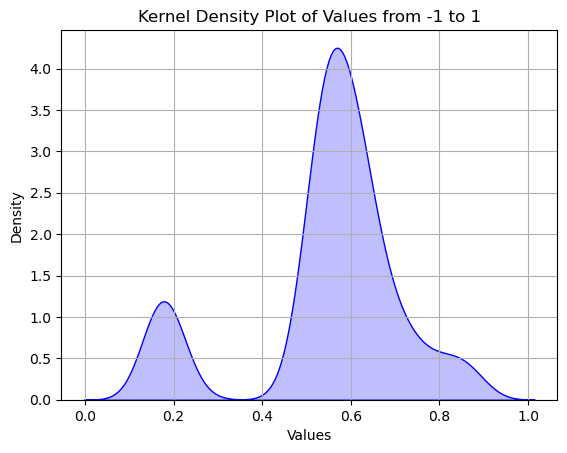

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt

Max_List = dft['Max'].values

sns.kdeplot(Max_List, color='blue', shade=True)
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Values from -1 to 1')
plt.grid(True)
plt.show()

/tmp/ipykernel_277900/1862721131.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(Min_List, color='blue', shade=True)


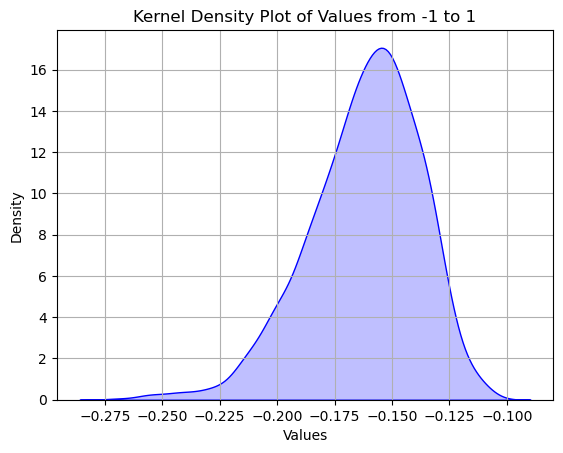

In [158]:
Min_List = dft['Min'].values

sns.kdeplot(Min_List, color='blue', shade=True)
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Values from -1 to 1')
plt.grid(True)
plt.show()

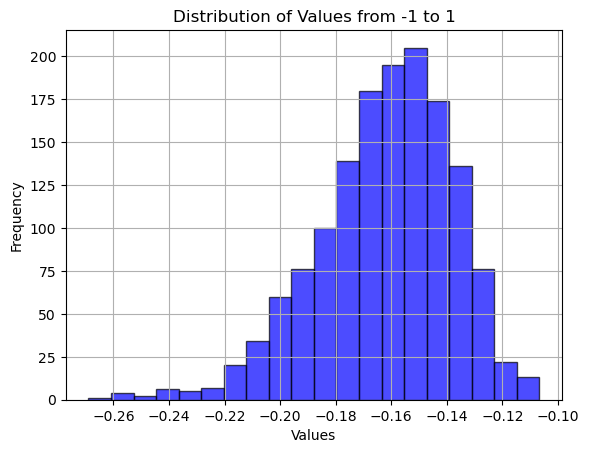

In [159]:
plt.hist(Min_List, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Values from -1 to 1')
plt.grid(True)
plt.show()

In [ ]:
plt.hist(Max_List, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Values from -1 to 1')
plt.grid(True)
plt.show()

In [167]:
dfscript.rename(columns={0: 'Title'}, inplace= True)
dfscript

,Title,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,300,cluster
0,No Country for Old Men,-0.791124,-0.827768,-2.360581,1.835622,-0.538139,-1.668736,-2.025473,-0.549377,-1.938114,...,0.132890,-0.852833,-0.949367,1.291457,1.415287,0.124992,-1.362445,0.973660,-2.840497,36
1,Jerry Maguire,1.562291,0.452415,-0.337816,0.626962,-1.066654,-1.055062,0.661907,1.013458,1.237970,...,0.958692,0.578849,0.267543,-1.528411,-1.252558,-0.492581,-2.604457,-0.121499,-0.674109,0
2,Addams Family The,-0.781085,-0.268572,-1.152856,-0.789217,-1.480119,1.018391,-1.064225,-0.682331,-1.166818,...,1.384553,1.985418,-1.308616,1.100558,0.067445,-0.019421,0.164875,0.970920,0.310238,20
3,Machine Gun Preacher,0.848836,-0.905038,-2.310214,-2.289747,0.020413,1.066912,-0.593755,-0.625307,0.301042,...,0.439940,0.690638,0.452343,2.399996,-0.256926,0.426104,-0.822776,0.512721,-2.063717,1
4,Things My Father Never Taught Me The,0.216570,0.401216,-0.413419,0.825096,-0.884562,0.108544,-0.489815,0.583705,-0.433195,...,0.609140,-0.154283,-0.692036,0.095477,0.460662,-0.232961,-0.143289,0.398403,-0.832446,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,The Woodsman,-2.776354,0.032898,0.391720,-0.245273,-1.928038,-0.302417,-1.617118,-2.136188,1.945119,...,0.420008,-2.426943,0.035611,-0.903716,-0.197647,-0.044761,-1.540320,3.638032,-1.727257,13
2055,Avenge,0.553771,0.240208,3.183108,2.514931,-2.796172,2.100915,-3.388995,1.501770,1.450658,...,-0.056473,-0.361405,-5.482206,1.087394,0.794488,1.315698,2.570142,1.482233,0.968328,32
2056,An American Tragedy,-0.254116,-0.484543,0.627811,-0.109481,-1.643628,1.150059,0.205151,1.505989,-1.174526,...,0.851880,1.179052,0.443939,0.631046,-1.645844,2.029704,-2.565536,-0.519970,-1.058560,20
2057,Highlander 4,-2.033680,0.441704,-3.954068,-0.133675,-2.816425,-0.938695,-2.530867,0.660542,1.097587,...,3.033679,1.226215,2.049504,1.403564,0.601398,0.105676,0.695220,1.957744,-1.265259,32


In [160]:

from sklearn.cluster import KMeans

try:
    dfscript.drop(['cluster'])
except:
    pass

X = dfscript.iloc[:, 1:].values  


num_clusters = 40


kmeans = KMeans(n_clusters=num_clusters, random_state=42)
dfscript['cluster'] = kmeans.fit_predict(X)


/home/gustamatos/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8c1edd7a60>
Traceback (most recent call last):
  File "/home/gustamatos/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/gustamatos/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gustamatos/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in 

In [187]:
def recommend(movie_selected):
    if type(movie_selected) == str:
        movie_selected = [movie_selected]

    watched_movies_vectors = dfscript[dfscript['Title'].isin(movie_selected)].iloc[:, 1:-1].values
    average_vector = watched_movies_vectors.mean(axis=0)

    watched_movies_cluster = kmeans.predict([average_vector])

    cluster_movies = dfscript[dfscript['cluster'] == watched_movies_cluster[0]]
    cluster_movies = cluster_movies[~cluster_movies['Title'].isin(movie_selected)]

    similarities = cosine_similarity([average_vector], cluster_movies.iloc[:, 1:-1].values)
    cluster_movies['similarity'] = similarities[0]

    cluster_movies = cluster_movies.sort_values(by='similarity', ascending=False)

    top_recommendations = cluster_movies[['Title', 'similarity']].head(5)
    print(f"Top Recommendations for '{movie_selected}':")

    return print(top_recommendations)

In [188]:
recommend(['No Country for Old Men', 'Mean Girls'])

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f8c1ba2b240>
Traceback (most recent call last):
  File "/home/gustamatos/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/gustamatos/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/gustamatos/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/gustamatos/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' ob

Top Recommendations for '['No Country for Old Men', 'Mean Girls']':
                        Title  similarity
1003       The Usual Suspects    0.458396
1181            Apartment The    0.441792
1137           Field of Dream    0.438593
759   In The Heat of the Nigh    0.422041
163         The Hateful Eight    0.420446
